## EKSPERYMENT 1
### Komputer.

Część 1: Przygotowanie danych i trenowanie klasyfikatorów

Część 2: Dane, metoda

Część 3: Badanie jakości w strumieniu o zmiennej strudności

## Część 1: Trenowanie

In [10]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Prepare trainig data
train_data = torchvision.datasets.SVHN('./files/', 
                                  split='test', #Tak.
                                  download=True)

train_X = (torch.tensor(train_data.data)/255).to(torch.float)
train_y = train_data.labels

dataset = TensorDataset(torch.Tensor(train_X),torch.Tensor(train_y))
dataloader = DataLoader(dataset, batch_size=64)

print(train_X.shape)
print(train_y.shape)

Using downloaded and verified file: ./files/test_32x32.mat
torch.Size([26032, 3, 32, 32])
(26032,)


In [11]:
from architectures import CNN, CNN1_10_Network, CNN1_5_Network, CNN2_10_20_Network, CNN2_5_10_Network, CNN3_5_10_20_Network, FC_Network

# Initialize and train classifiers
max_training_epochs = 250
training_support_level = 0.8

clfs = [
    CNN(architecure=FC_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN1_5_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN1_10_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN2_5_10_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN2_10_20_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN3_5_10_20_Network(img_depth=3, x_input_size=32)),  
]

loss_fn = torch.nn.CrossEntropyLoss()

for clf_id, clf in enumerate(clfs):
    optimizer = torch.optim.SGD(clf.parameters(), lr=1e-2)

    for e in range(max_training_epochs):
        if e==0:
            clf.train(dataloader, loss_fn, optimizer)
        else:

            proba = nn.Softmax(dim=1)( clf(train_X))
            max_proba = torch.max(proba, dim=1)[0] 
            mean_proba = torch.mean(max_proba).detach().numpy() # średnie wsparcie decyzyjne

            if mean_proba>training_support_level:
                print(clf_id, e, mean_proba)
                break
            
            clf.train(dataloader, loss_fn, optimizer)
        
        if e%50==1:
            print(clf_id, e, mean_proba)
            

0 1 0.18599333
0 51 0.74674827
0 73 0.8031468
1 1 0.18966399
1 51 0.7343835
1 101 0.78045094
1 151 0.79133505
1 201 0.79741496
1 230 0.8000609
2 1 0.1945208
2 50 0.80065465
3 1 0.18893427
3 21 0.80185467
4 1 0.18803671
4 23 0.801934
5 1 0.18952617
5 32 0.80242145


In [78]:
import numpy as np

def get_th(chunk_size):
    max_probas=[]
    for c in clfs:
        proba = nn.Softmax(dim=1)(c(train_X))
        max_proba = torch.max(proba, dim=1)[0]
        max_probas.append(max_proba.detach().numpy())
        
    mp = np.array(max_probas).flatten()
    aa = int(len(mp)/chunk_size)
    mp = mp[:aa*chunk_size]
    mp = mp.reshape(aa,chunk_size)
    mp = np.mean(mp, axis=1)

    n_bins=7
    bin_size = int(len(mp)/n_bins)

    th = []
    argsort_mp = np.argsort(mp)

    for b in range(n_bins-1):
        th.append(mp[argsort_mp[b*bin_size]])

    # th.append(1)
    th.reverse()
    # th.pop()
    th[0]=1.
    return th
    

In [17]:
# Save classifers
for c_id, c in enumerate(clfs):
    torch.save(c, 'models/%i.pt' % c_id)

## Część 2: Przygotowanie danych i CDoS

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from ConditionalEvidenceStream import ConditionalEvidenceStream
from utils import make_condition_map, mix_to_factor
import concepts
import torch
import torchvision

# Load data
stream_data = torchvision.datasets.SVHN('./files/', 
                                  split='train', 
                                  download=True)

X = torch.tensor(stream_data.data)/255
y = stream_data.labels

X_pca = PCA(n_components=0.8).fit_transform(X.reshape(X.shape[0],-1))
X_pca -= np.mean(X_pca, axis=0)
X_pca /= np.std(X_pca, axis=0)

factor = mix_to_factor(X_pca)

Using downloaded and verified file: ./files/train_32x32.mat


In [44]:
# Load models

clfs=[]
for c_id in range(6):
    clfs.append(torch.load('models/%i.pt' % c_id))

## Część 3: Eksperyment

In [79]:

import time
from sklearn.metrics import accuracy_score
from Method import CDoS_T

# Experimental setup
n_chunks = 1000
chunk_size = [5, 25, 50]
n_cycles = [3, 5, 10]
modes = {
    'instant': {'mode': 'instant'},
    'normal_1': {'mode': 'normal', 'sigma': 1},
    'normal_5': {'mode': 'normal', 'sigma': 5}
    }

accs = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
times = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
cdos_selected = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks))

for cs_id, cs in enumerate(chunk_size):
    for n_c_id, nc in enumerate(n_cycles):
        for m_id, mode in enumerate(modes):

            condition_map = make_condition_map(n_cycles=nc,
                                            n_concepts=500,
                                            factor=factor,
                                            factor_range=(0.05,0.95))

            cp = concepts.concept_proba(n_concepts=500,
                                        n_chunks=n_chunks,
                                        normalize=True,
                                        **modes[mode])

            stream = ConditionalEvidenceStream(X, y,
                                            condition_map.T,
                                            cp,
                                            chunk_size=cs,
                                            fragile=False)
            
            

            # Prepare method
            thresholds = get_th(chunk_size=cs)
            cdos = CDoS_T(clfs=clfs, thresholds=thresholds)

            with torch.no_grad():

                for chunk_id in range(n_chunks):
                    _X, _y = stream.get_chunk()
                    
                    
                    # Regular clfs
                    for c_id, c in enumerate(clfs):
                        start = time.time()
                        proba = nn.Softmax(dim=1)(c(_X))
                        p = torch.argmax(proba, dim=1)    
                        elapsed = time.time()-start
                        
                        accs[cs_id, n_c_id, m_id, chunk_id, c_id] = accuracy_score(_y, p)
                        times[cs_id, n_c_id, m_id, chunk_id, c_id] = elapsed
                        
                    #CDos
                    start = time.time()
                    p = cdos.predict(_X)
                    elapsed = time.time()-start
                    
                    accs[cs_id, n_c_id, m_id, chunk_id, -1] = accuracy_score(_y, p)
                    times[cs_id, n_c_id, m_id, chunk_id, -1] = elapsed
                    
                    cdos_selected[cs_id, n_c_id, m_id, chunk_id] = cdos.curr_clf_id
                    
                # print(accs[cs_id, n_c_id, m_id, chunk_id])
                # print(times[cs_id, n_c_id, m_id, chunk_id])
                print(cs, nc, mode, np.unique(cdos_selected[cs_id, n_c_id, m_id], return_counts=True))
                
                np.save('results/e1_accs.npy', accs)
                np.save('results/e1_times.npy', times)
                np.save('results/e1_selected.npy', cdos_selected)
            
            


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


5 3 instant (array([0., 1., 2., 3., 4.]), array([ 21, 199, 417, 302,  61]))
5 3 normal_1 (array([0., 1., 2., 3., 4.]), array([ 83, 228, 318, 262, 109]))
5 3 normal_5 (array([0., 1., 2., 3., 4.]), array([ 46, 202, 360, 287, 105]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


5 5 instant (array([0., 1., 2., 3., 4.]), array([167, 270, 290, 215,  58]))
5 5 normal_1 (array([0., 1., 2., 3., 4.]), array([117, 240, 270, 239, 134]))
5 5 normal_5 (array([0., 1., 2., 3., 4.]), array([101, 231, 324, 264,  80]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


5 10 instant (array([0., 1., 2., 3., 4.]), array([ 67, 177, 319, 316, 121]))
5 10 normal_1 (array([0., 1., 2., 3., 4.]), array([ 57, 194, 292, 291, 166]))
5 10 normal_5 (array([0., 1., 2., 3., 4.]), array([ 37, 186, 355, 294, 128]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


25 3 instant (array([0., 1., 2., 3., 4.]), array([ 10,  50, 190, 366, 384]))
25 3 normal_1 (array([0., 1., 2., 3., 4.]), array([ 10,  63, 222, 378, 327]))
25 3 normal_5 (array([0., 1., 2., 3., 4.]), array([ 45, 149, 309, 326, 171]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


25 5 instant (array([0., 1., 2., 3., 4.]), array([ 19,  49, 146, 371, 415]))
25 5 normal_1 (array([0., 1., 2., 3., 4.]), array([ 21,  95, 192, 338, 354]))
25 5 normal_5 (array([0., 1., 2., 3., 4.]), array([ 35,  75, 101, 347, 442]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


25 10 instant (array([0., 1., 2., 3., 4.]), array([ 45, 100, 254, 357, 244]))
25 10 normal_1 (array([0., 1., 2., 3., 4.]), array([ 21,  72, 171, 378, 358]))
25 10 normal_5 (array([0., 1., 2., 3., 4.]), array([ 22, 129, 254, 326, 269]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


50 3 instant (array([0., 1., 2., 3., 4., 5.]), array([ 10,  12,  49, 255, 663,  11]))
50 3 normal_1 (array([0., 1., 2., 3., 4.]), array([ 10,  28,  37, 231, 694]))
50 3 normal_5 (array([0., 1., 2., 3., 4.]), array([ 10,  11,  54, 269, 656]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


50 5 instant (array([0., 1., 2., 3., 4.]), array([ 10,  23,  73, 262, 632]))
50 5 normal_1 (array([0., 1., 2., 3., 4.]), array([ 10,  25,  87, 272, 606]))
50 5 normal_5 (array([0., 1., 2., 3., 4.]), array([ 10,  36,  74, 259, 621]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


50 10 instant (array([0., 1., 2., 3., 4.]), array([ 21,  45,  79, 245, 610]))
50 10 normal_1 (array([0., 1., 2., 3., 4.]), array([ 10,  25,  50, 246, 669]))
50 10 normal_5 (array([0., 1., 2., 3., 4., 5.]), array([ 10,  24, 142, 301, 512,  11]))


## Analiza wyników

In [80]:
accs = np.load('results/e1_accs.npy')
times = np.load('results/e1_times.npy')

print(accs.shape, times.shape)

#cs_id, n_c_id, m_id, chunk_id, c_id

(3, 3, 3, 1000, 7) (3, 3, 3, 1000, 7)


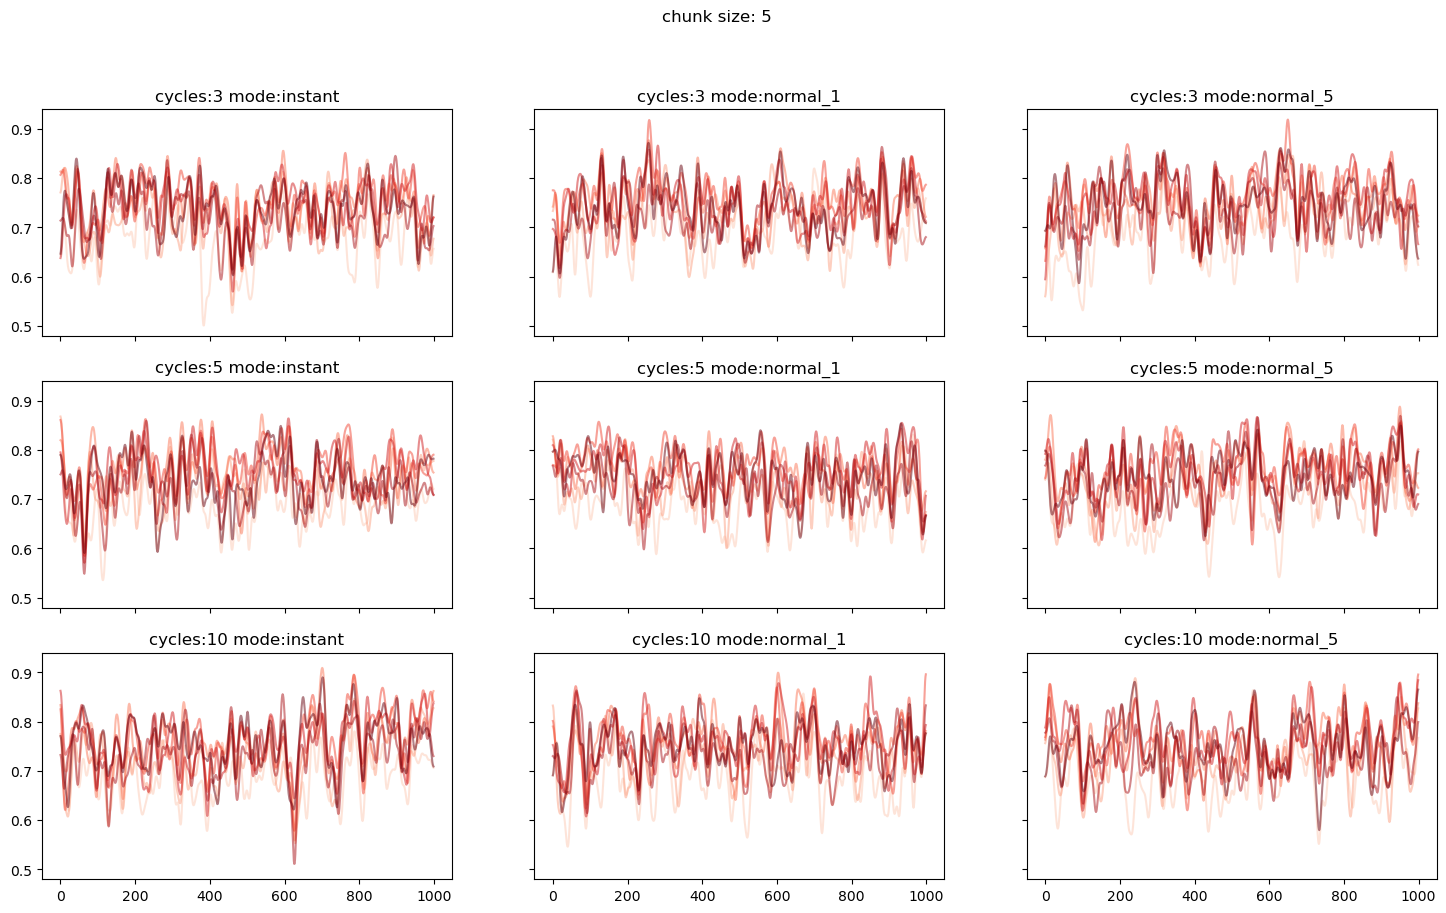

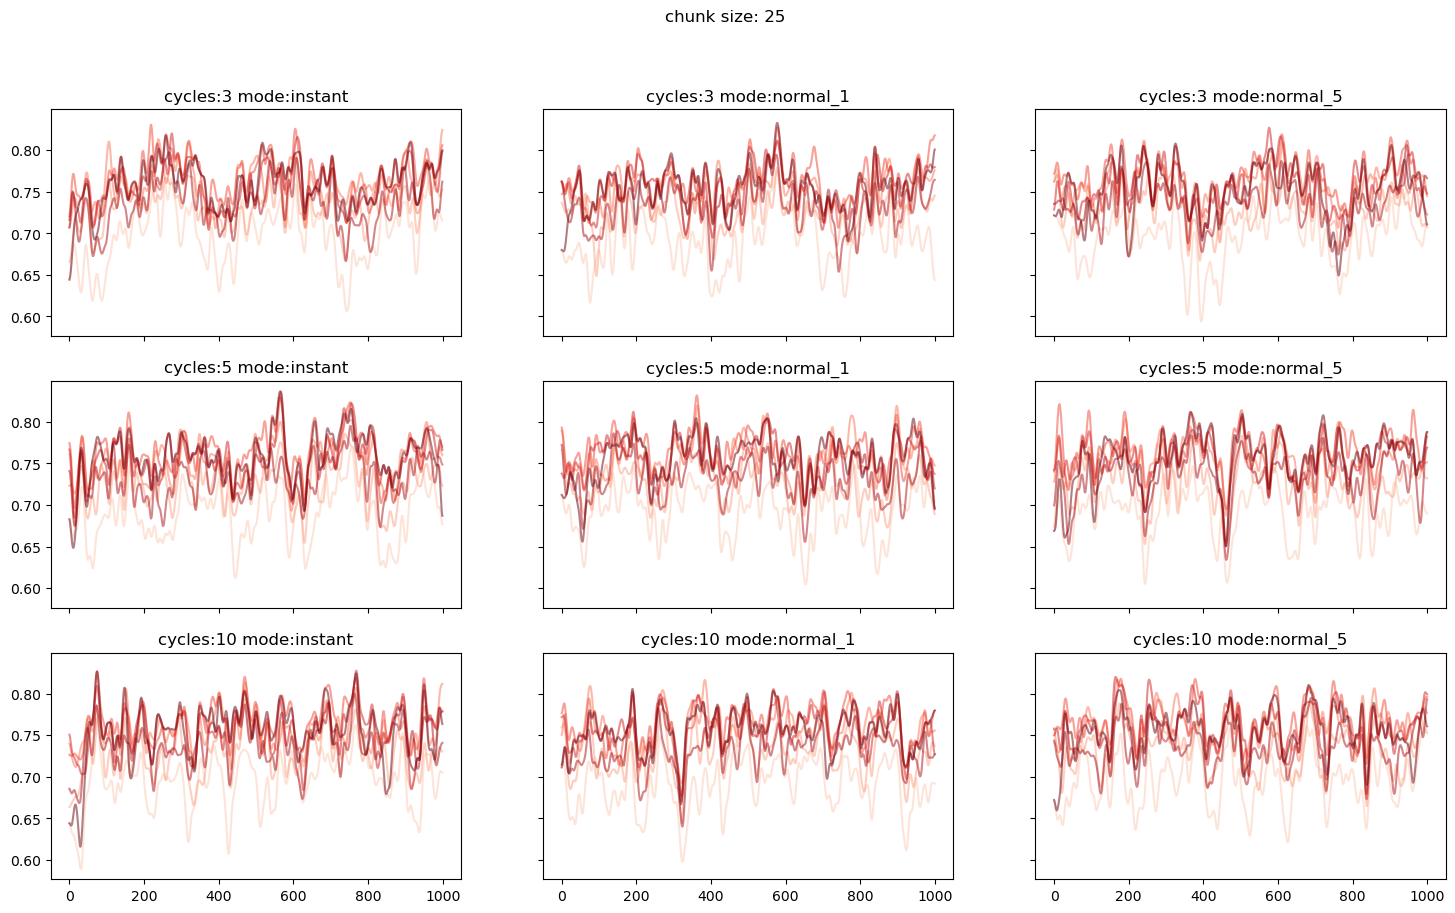

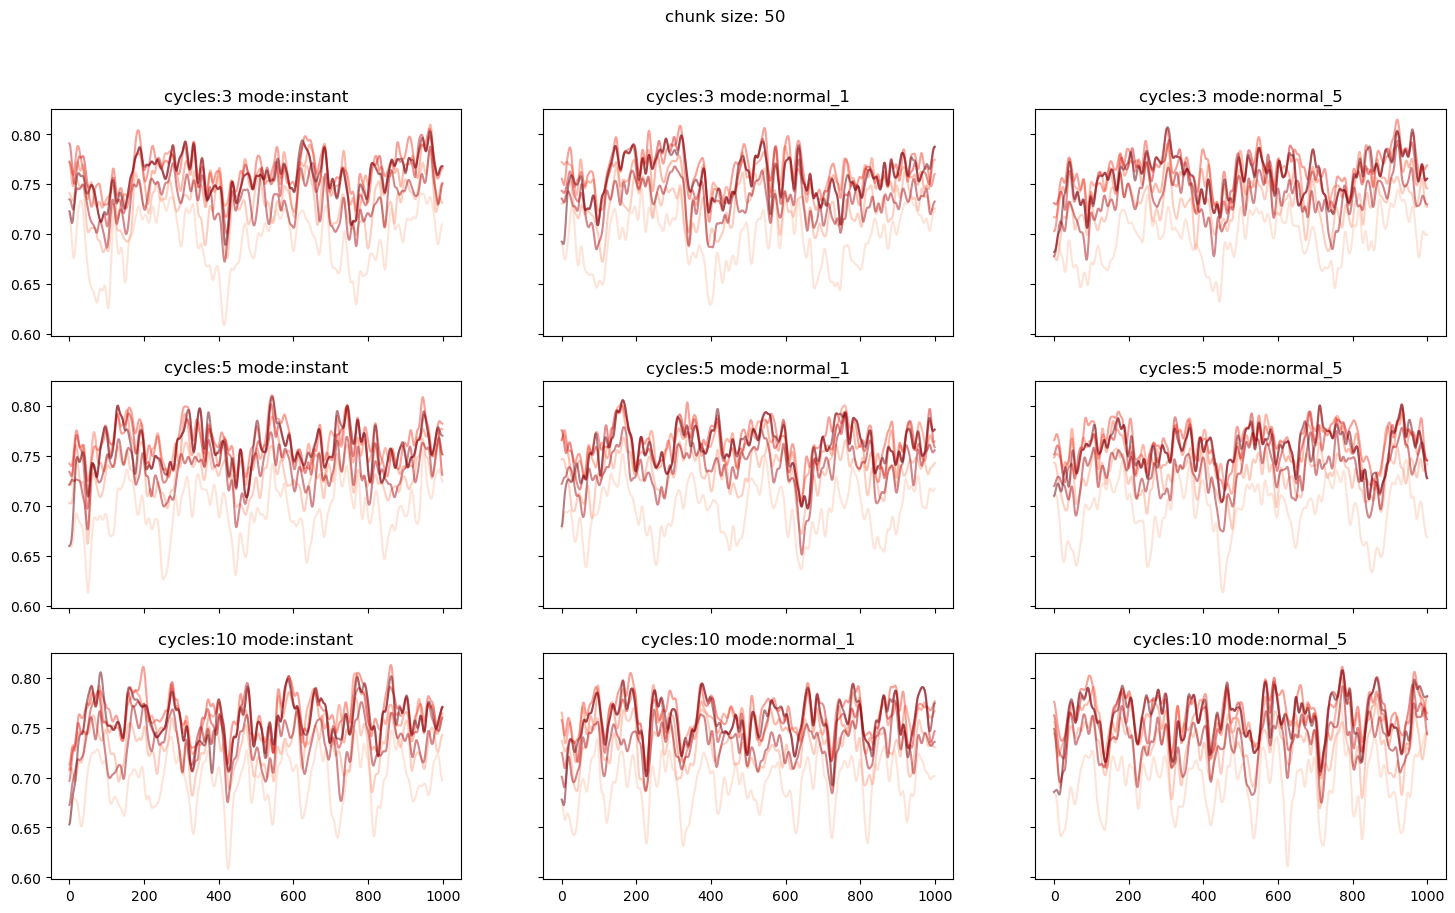

In [84]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

s=5
cols = plt.cm.Reds(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)

    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('cycles:%i mode:%s' % (n_c, mode))
            for method_id in range(7):
                temp = accs[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
    
    plt.show()
    
                

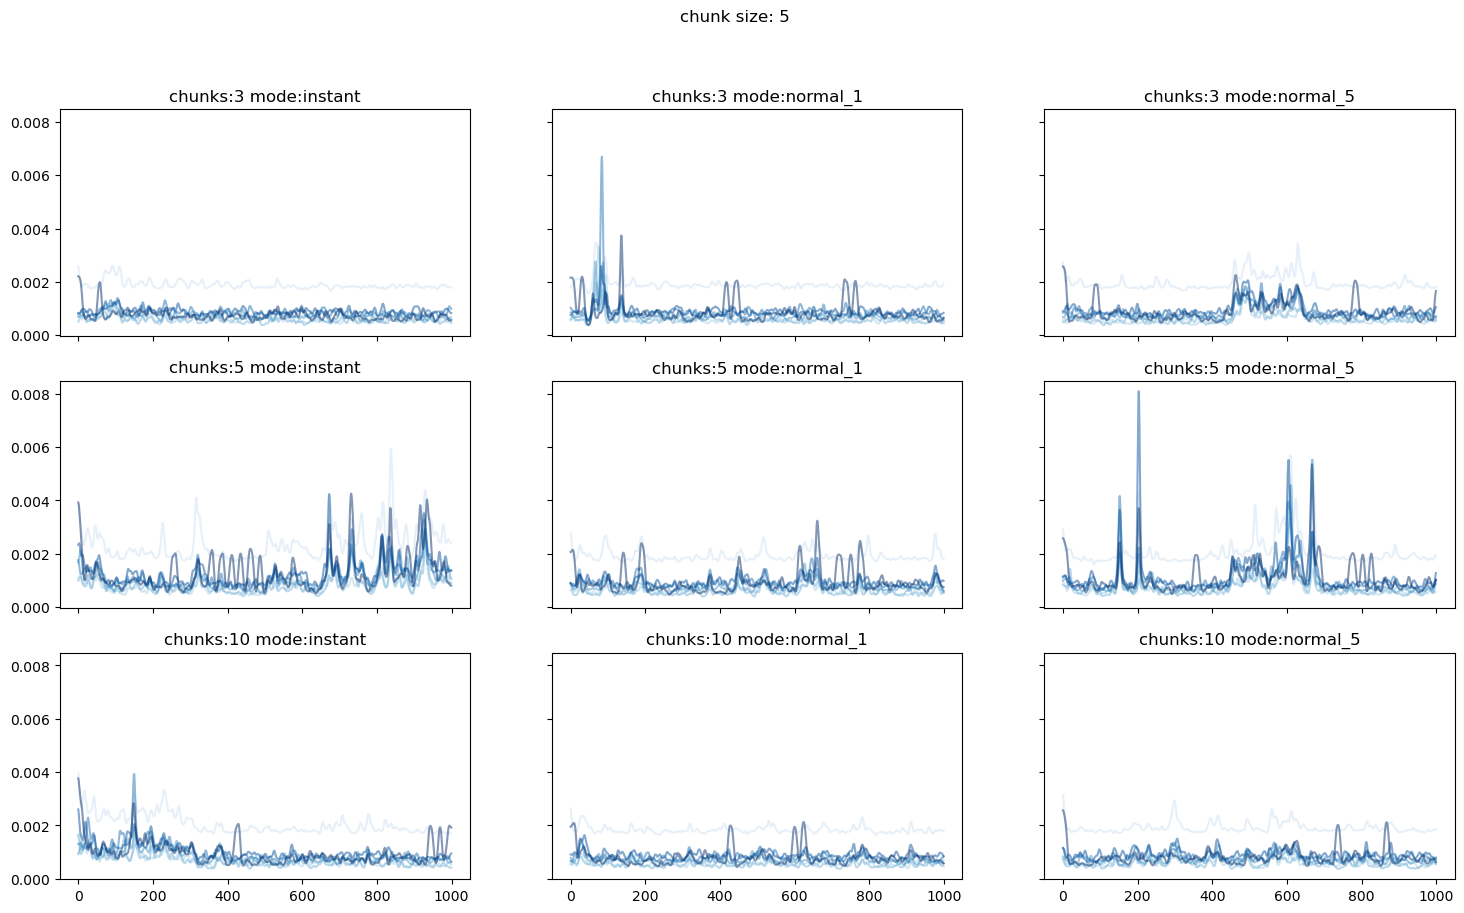

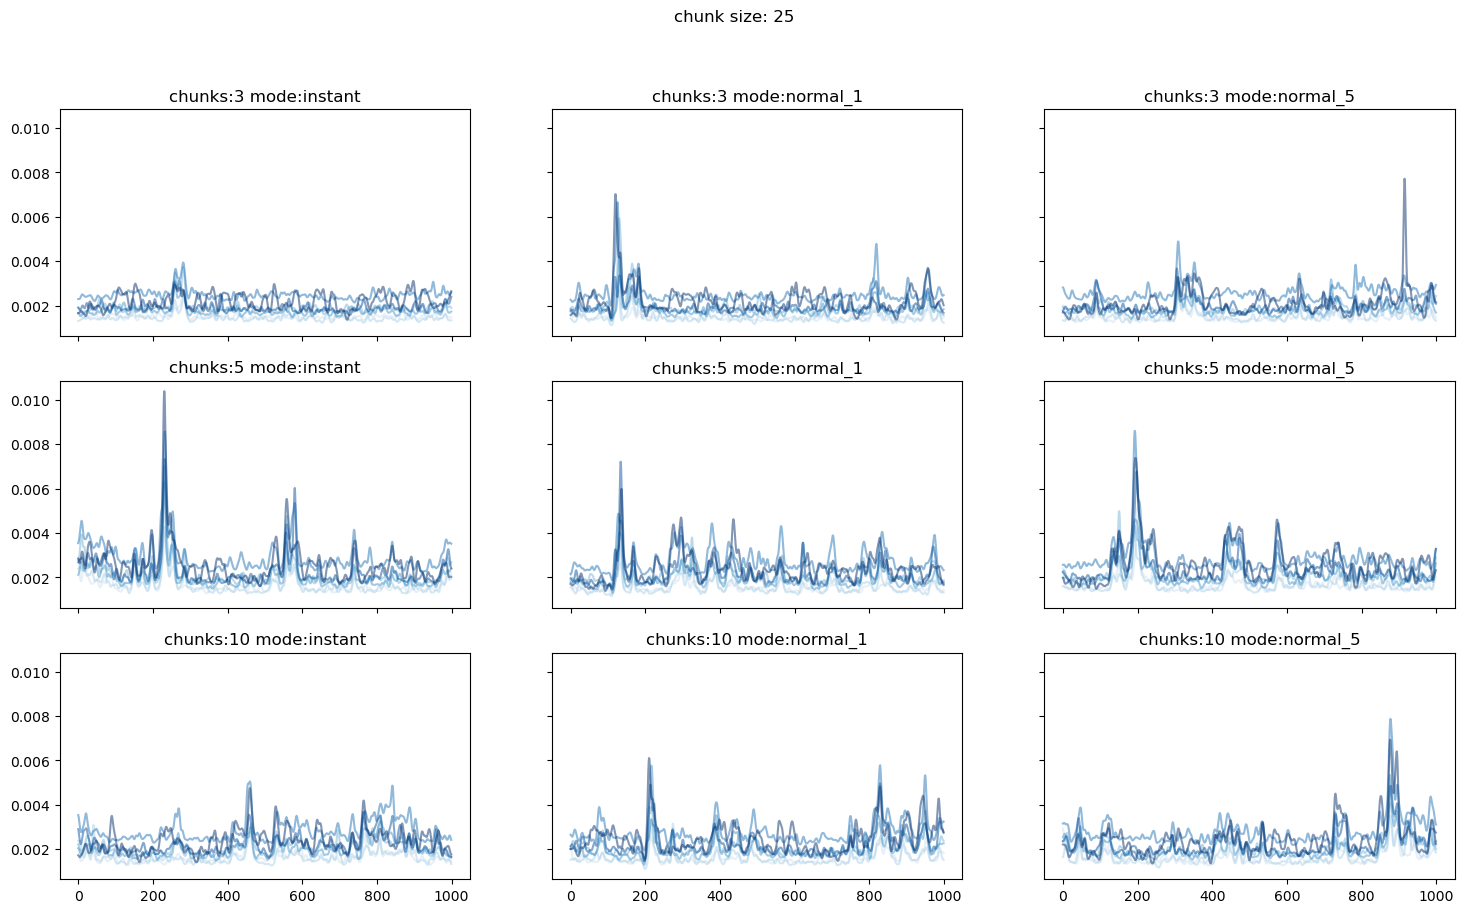

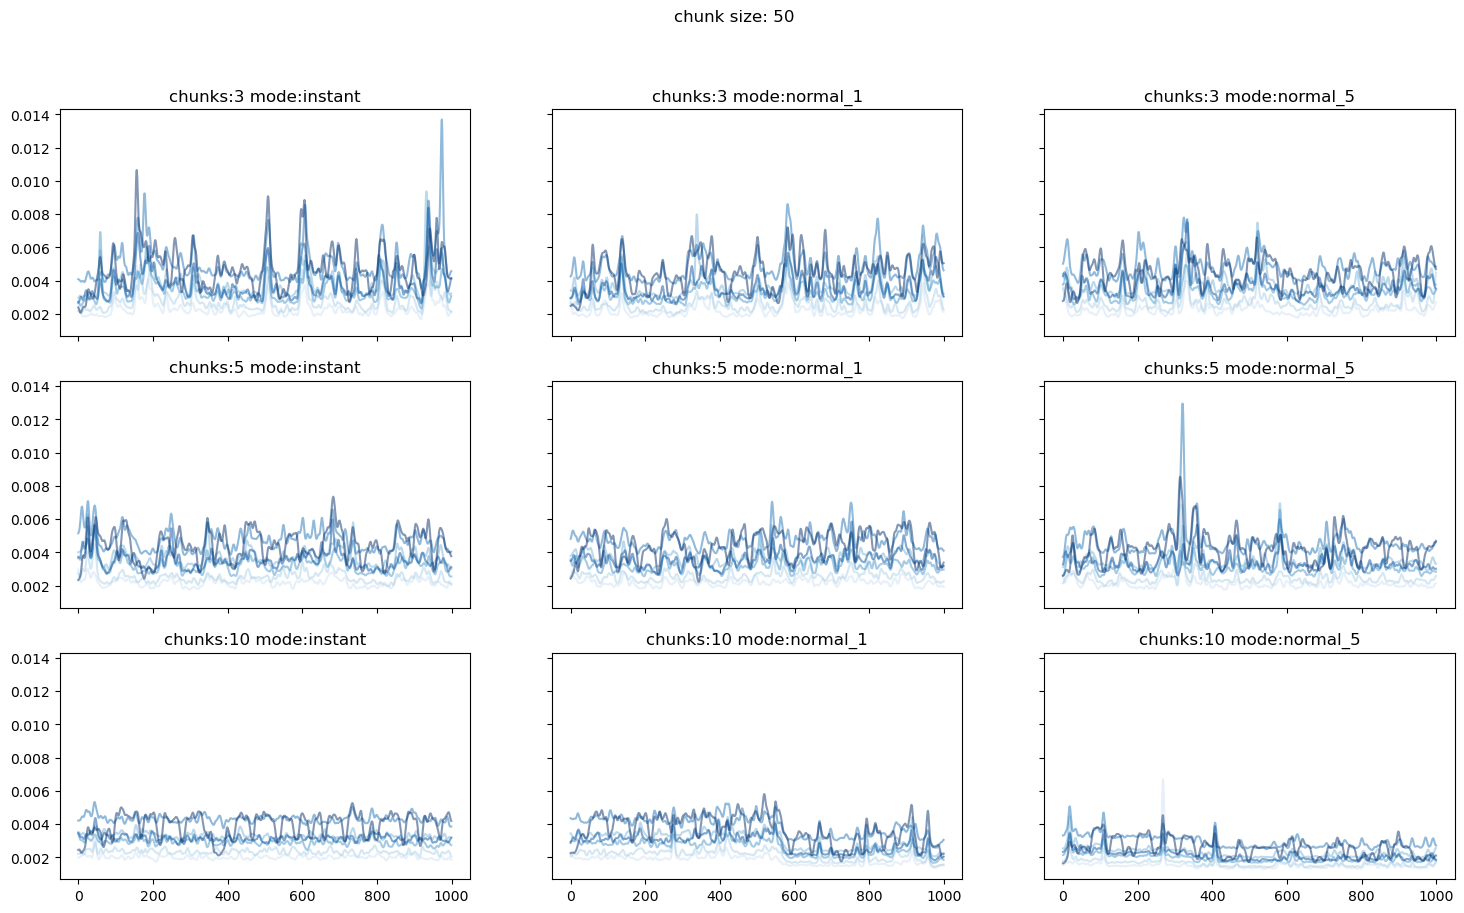

In [82]:
cols = plt.cm.Blues(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)

    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('chunks:%i mode:%s' % (n_c, mode))
            for method_id in range(7):
                temp = times[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
    
    plt.show()

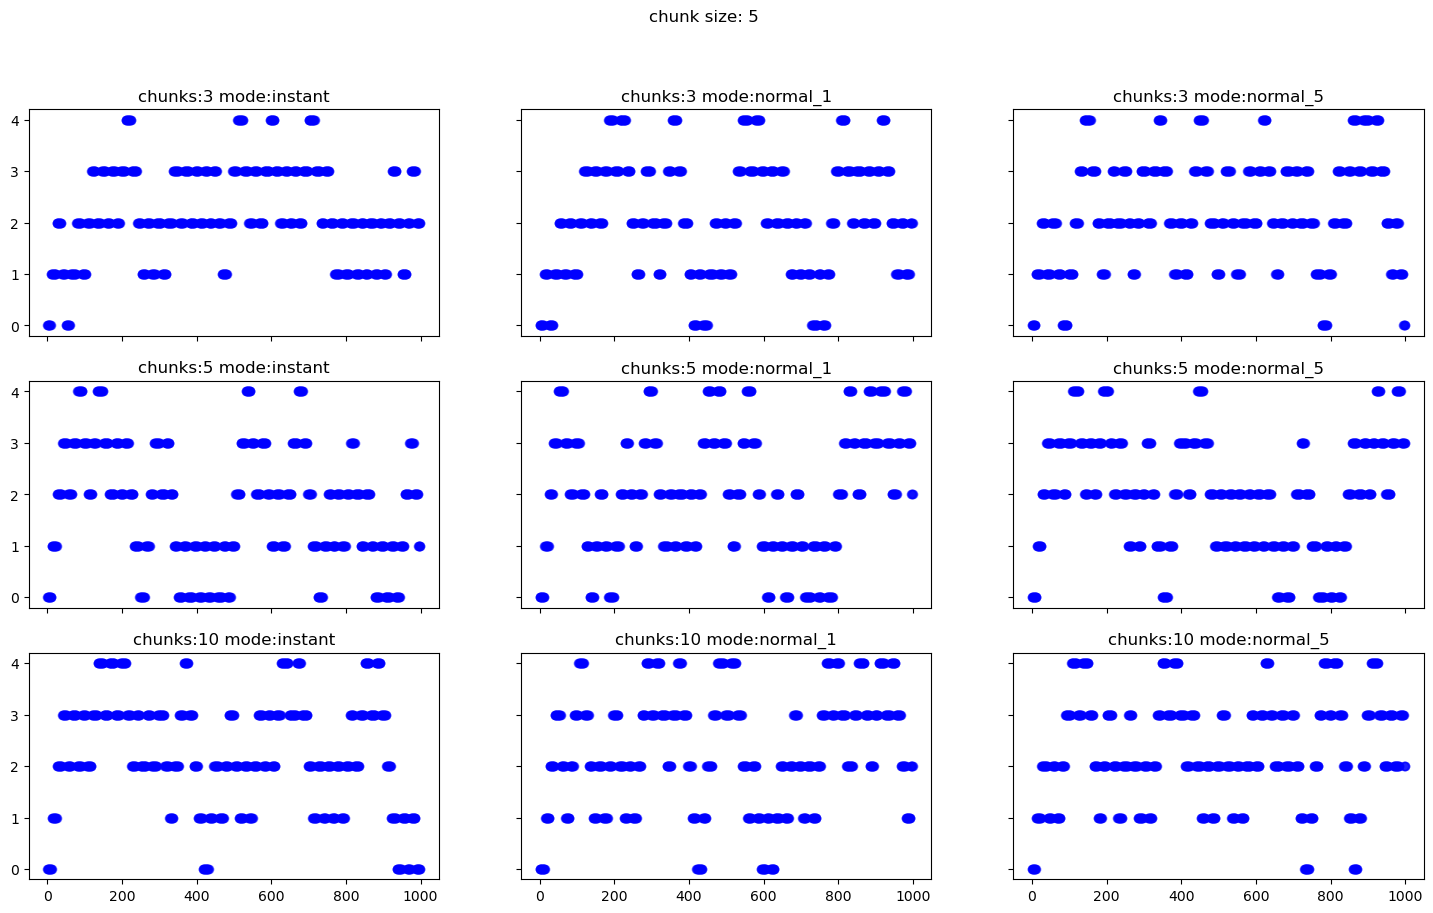

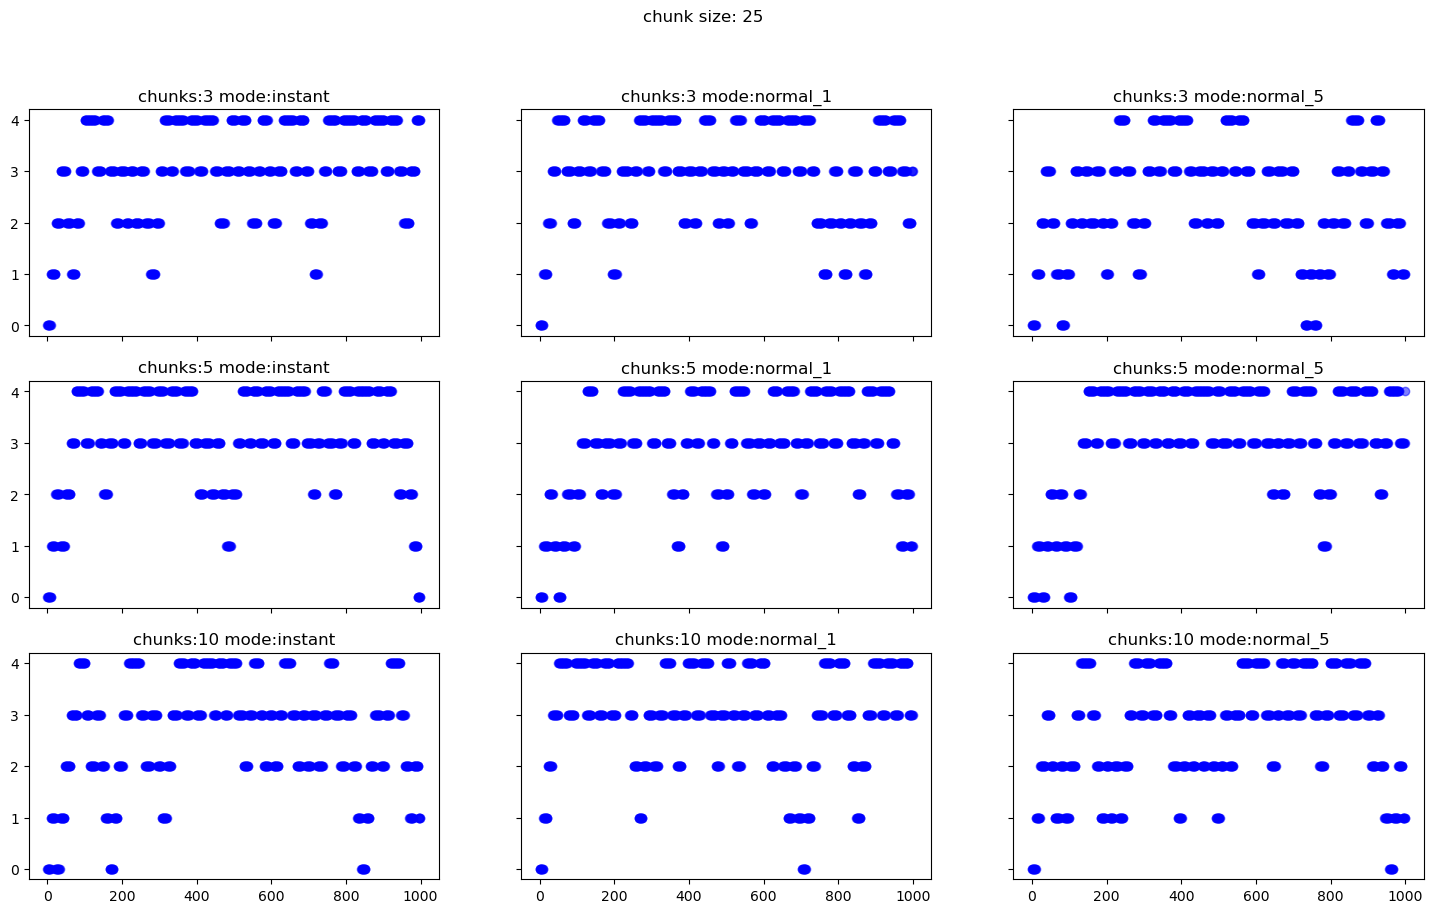

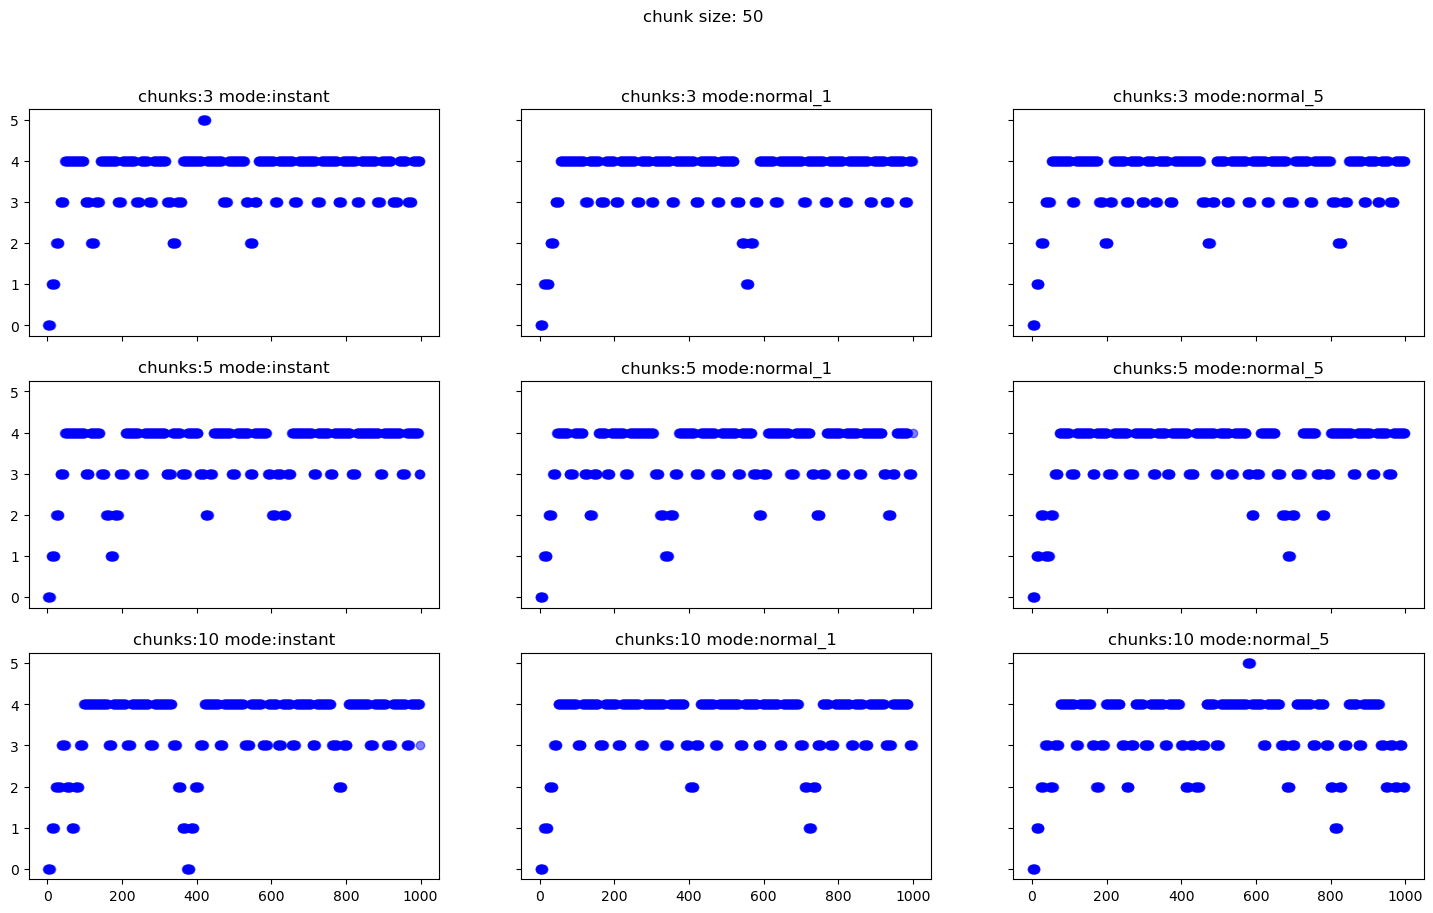

In [83]:
sel = np.load('results/e1_selected.npy')

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)
    
    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('chunks:%i mode:%s' % (n_c, mode))
            
            temp = sel[c_id, n_c_id, mode_id]
            ax[n_c_id, mode_id].scatter(np.arange(n_chunks), temp, c='blue', alpha=0.5)

    plt.show()